In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
DATA_PATH = Path("../data/raw/raw.csv")

In [2]:
df = pd.read_csv(DATA_PATH, parse_dates=["start_time", "end_time"])
df.head()

,item_id,category,start_price,start_time,duration_hours,end_time,num_bids,end_price,views,watchlist_count
0,1000000,motors,35.72,2025-01-01 00:00:00,24,2025-01-02 00:00:00,26,46.64,303,13
1,1000001,toys,231.84,2025-01-01 06:00:00,120,2025-01-06 06:00:00,20,284.03,244,16
2,1000002,fashion,68.87,2025-01-01 12:00:00,96,2025-01-05 12:00:00,18,82.05,235,13
3,1000003,motors,80.40,2025-01-01 18:00:00,72,2025-01-04 18:00:00,25,102.22,289,13
4,1000004,electronics,317.98,2025-01-02 00:00:00,72,2025-01-05 00:00:00,14,384.37,188,9


In [3]:
df.info()
df.describe()

df.isna().sum()

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   item_id          1000 non-null   int64         
 1   category         1000 non-null   object        
 2   start_price      1000 non-null   float64       
 3   start_time       1000 non-null   datetime64[ns]
 4   duration_hours   1000 non-null   int64         
 5   end_time         1000 non-null   datetime64[ns]
 6   num_bids         1000 non-null   int64         
 7   end_price        1000 non-null   float64       
 8   views            1000 non-null   int64         
 9   watchlist_count  1000 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(1)
memory usage: 78.2+ KB


np.int64(0)

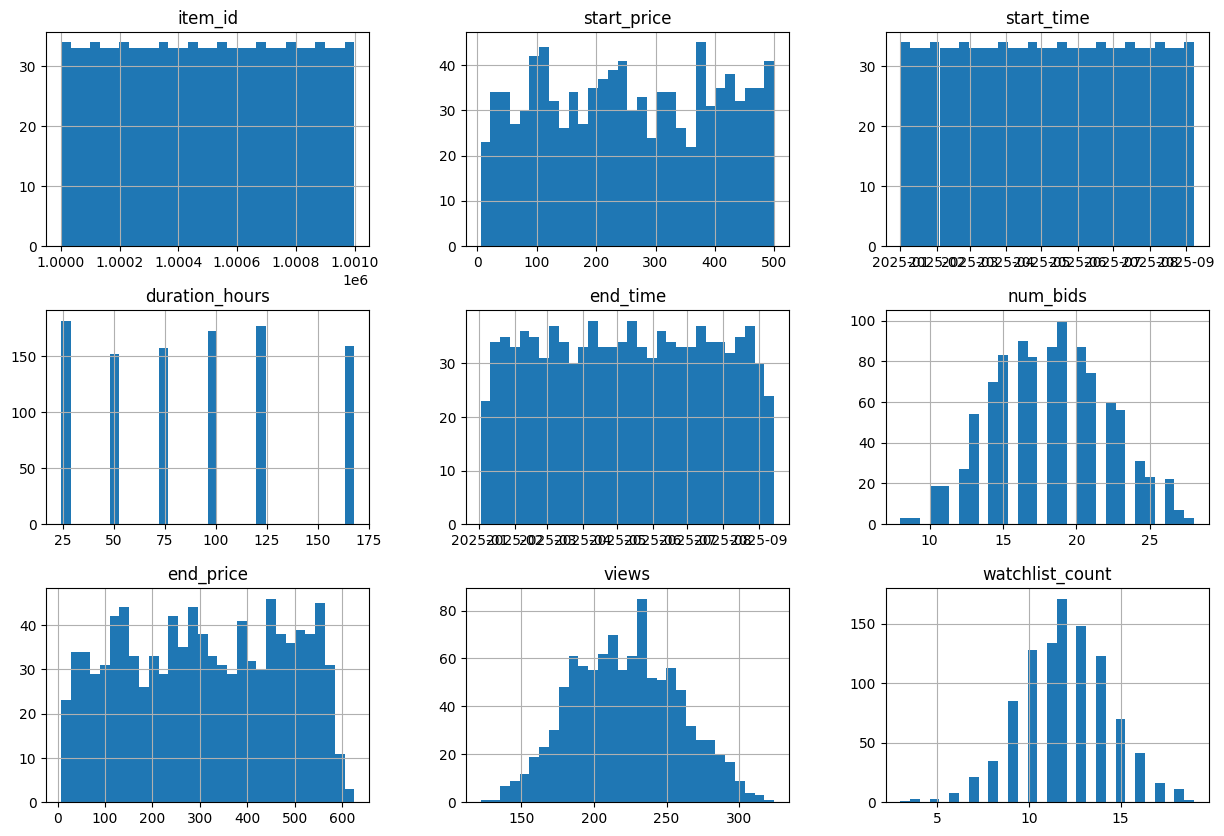

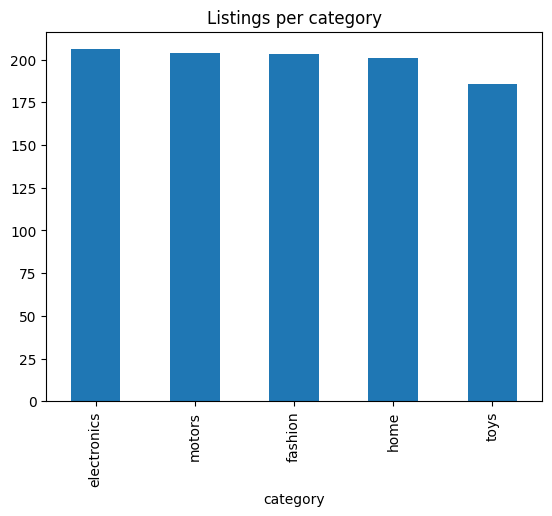

In [4]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

df['category'].value_counts().plot(kind='bar')
plt.title("Listings per category")
plt.show()

In [5]:
def add_time_features(df):
    df = df.copy()
    df['duration_h'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600
    df['hour'] = df['start_time'].dt.hour
    df['dow'] = df['start_time'].dt.dayofweek
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    df['month'] = df['start_time'].dt.month
    return df

df_fe = add_time_features(df)
df_fe.head()

,item_id,category,start_price,start_time,duration_hours,end_time,num_bids,end_price,views,watchlist_count,duration_h,hour,dow,is_weekend,month
0,1000000,motors,35.72,2025-01-01 00:00:00,24,2025-01-02 00:00:00,26,46.64,303,13,24.0,0,2,0,1
1,1000001,toys,231.84,2025-01-01 06:00:00,120,2025-01-06 06:00:00,20,284.03,244,16,120.0,6,2,0,1
2,1000002,fashion,68.87,2025-01-01 12:00:00,96,2025-01-05 12:00:00,18,82.05,235,13,96.0,12,2,0,1
3,1000003,motors,80.40,2025-01-01 18:00:00,72,2025-01-04 18:00:00,25,102.22,289,13,72.0,18,2,0,1
4,1000004,electronics,317.98,2025-01-02 00:00:00,72,2025-01-05 00:00:00,14,384.37,188,9,72.0,0,3,0,1


In [6]:
target = "num_bids"  

features = ["category", "start_price", "hour", "dow", "is_weekend", "duration_h"]

df_sorted = df_fe.sort_values("start_time")
split_idx = int(len(df_sorted) * 0.8)

X_train = df_sorted[features].iloc[:split_idx]
y_train = df_sorted[target].iloc[:split_idx]

X_test = df_sorted[features].iloc[split_idx:]
y_test = df_sorted[target].iloc[split_idx:]

len(X_train), len(X_test)

(800, 200)

In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = mean_squared_error(y_test, y_pred_base) ** 0.5
mape_base = mape(y_test, y_pred_base)

print(f"Naive baseline - MAE: {mae_base:.2f}, RMSE: {rmse_base:.2f}, MAPE: {mape_base:.2f}%")

Naive baseline - MAE: 3.24, RMSE: 3.84, MAPE: 19.39%


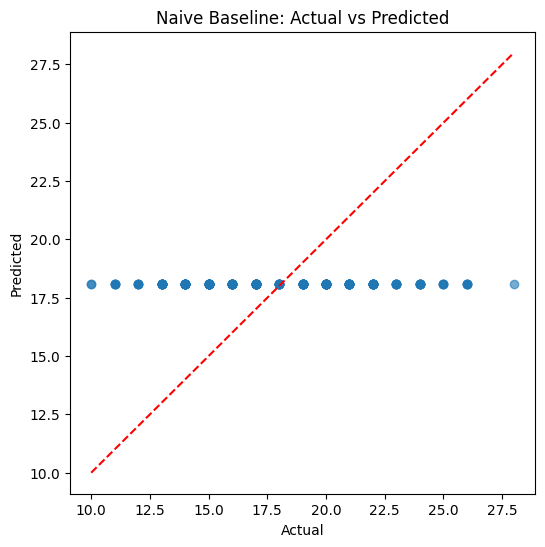

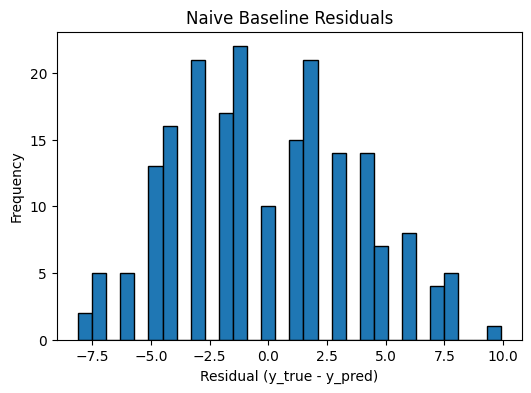

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_base, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Naive Baseline: Actual vs Predicted")
plt.show()

residuals = y_test - y_pred_base
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Naive Baseline Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preproc = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["category"])
    ],
    remainder="passthrough"
)

linreg = Pipeline([
    ("prep", preproc),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = mean_squared_error(y_test, y_pred_lin) ** 0.5
mape_lin = mape(y_test, y_pred_lin)

print(f"Linear Regression MAE: {mae_lin:.2f}, RMSE: {rmse_lin:.2f}, MAPE: {mape_lin:.2f}%")

Linear Regression MAE: 1.58, RMSE: 1.85, MAPE: 9.25%


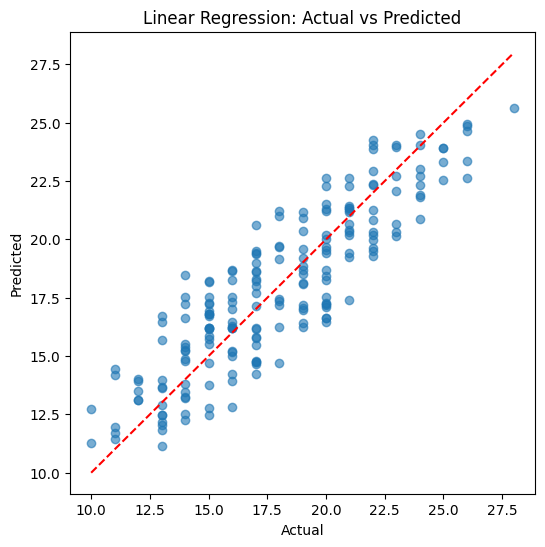

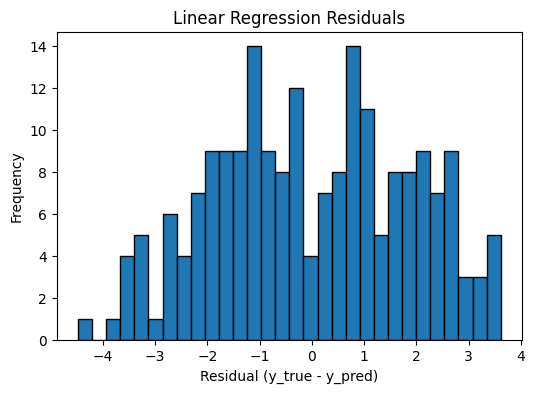

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lin, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

residuals_lin = y_test - y_pred_lin
plt.figure(figsize=(6,4))
plt.hist(residuals_lin, bins=30, edgecolor='k')
plt.title("Linear Regression Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()